## MPhil in Data Intensive Science
## Minor Module A1: Data Driven Radio Astronomy in the SKA Era
## Lecture 10: Time-domain radio astronomy II

## **Set Up The Notebook**

### **Import standard functions**

In [1]:
#import standard functions
import numpy as np
from matplotlib import pyplot as plt
import scipy.stats as stats
import sys
import os

### **Git clone required repository**

In [2]:
#check to see if we have downloaded the git repo necessary to run this notebook
if os.path.isdir('MPhilDIS/data'): #if yes, update the repo
    %cd MPhilDIS
    !git pull https://github.com/mbcxqcw2/MPhilDIS.git
    %cd ..
else: #if not, download the repo
    !git clone https://github.com/mbcxqcw2/MPhilDIS.git

# check that the data has been downloaded
!ls MPhilDIS/data

Cloning into 'MPhilDIS'...
remote: Enumerating objects: 22, done.
remote: Counting objects: 100% (22/22), done.
remote: Compressing objects: 100% (18/18), done.
remote: Total 22 (delta 4), reused 20 (delta 2), pack-reused 0 (from 0)
Receiving objects: 100% (22/22), 5.18 MiB | 6.06 MiB/s, done.
Resolving deltas: 100% (4/4), done.
bad_data.npy


### **Import Git repo functions**

In [3]:
#import bespoke functions
sys.path.insert(1,'MPhilDIS/functions/') #import our git cloned functions repo into path
from funcs import * #import our functions from the functions repo

# **Begin**

## **Introduction**

Welcome to Lecture 10 of your A1 minor module: ```Data Driven Radio Astronomy in the SKA Era``` This lecture serves as a practical follow-up to Lecture 9: ```Time Domain Astronomy (from baseband to discovery)```.

 During this lecture, we will walk through the process of analysing a common type of time domain radio astronomy data. Starting with a simulated ```dynamic spectrum```, we will develop practical experience in ```RFI mitigation```, and ```dedispersion```, and eventually identify which pulsar this dataset belongs to.


## **Task Overview**

The dataset in you will have downloaded while setting up this notebook is a simulated ```dynamic spectrum```: a 2-dimensional array of observed intensities at different ```observing frequencies``` as a function of ```time```. This data has been generated for a pulsar, and is corrupted with ```radio frequency interference (RFI)```

Your task is to load this dataset, RFI mitigate it, and dedisperse it to the correct ```dispersion measure (DM)``` in order to identify the pulsar.


### **Section 1: The dynamic spectrum**

#### **1A: Load the dataset and print its shape**



Your dynamic spectrum is stored in a numpy array at ```MPhilDIS/bad_data.npy```. In the cell below, load this dataset using the ```numpy.load()``` function, and study its shape using the ```numpy.shape()```function.


In [4]:
#Load your dataset in this cell

#load the data
data = np.load('MPhilDIS/data/bad_data.npy')

#print the shape of the data
print(data.shape)

(2500, 512)


As you can see, the data contains information for 2500 time samples and 512 frequency channels.

#### **1B: Plot the dynamic spectrum**

Now, let's plot this dataset as an image with frequency along the Y-axis and time along the X-axis. To do this, use the ```plt.imshow()``` function.

Hint: When plotting the image, make sure to use ```aspect='auto'``` to make it easier to read.


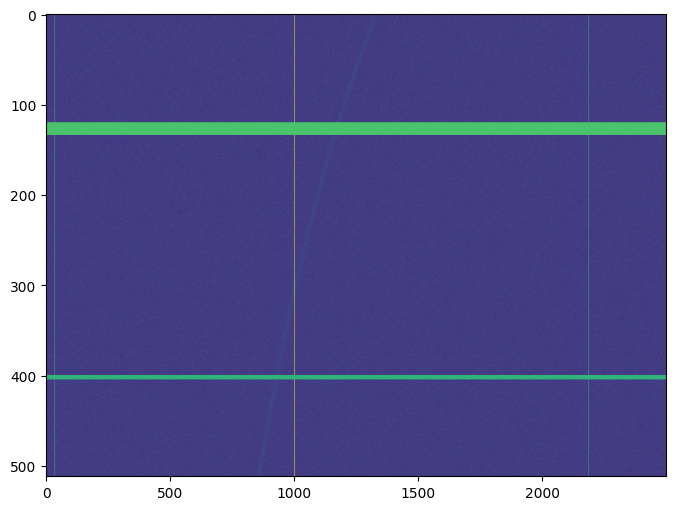

In [5]:
#Load your dataset in this cell

# initialise the plot
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)

#plot the dynamic spectrum
ax.imshow(data.T,aspect='auto')

plt.show()

#### **1C: Make sure the data is plotted correctly**

If plotted correctly, you should be able to see horizontal and vertical bands of ```RFI``` in your image. You may also be able to see a faint pulse.

As discussed in Lecture 9, when radio pulses travel through ionised environments they are ```dispersed```. As a result of this dispersion, higher frequency radiation arrives before lower frequency radiation. This results in a characteristic exponential sweep across the observing band.

Run the cell below and compare it to your result in Section 1B to ensure your data is plotted correctly.


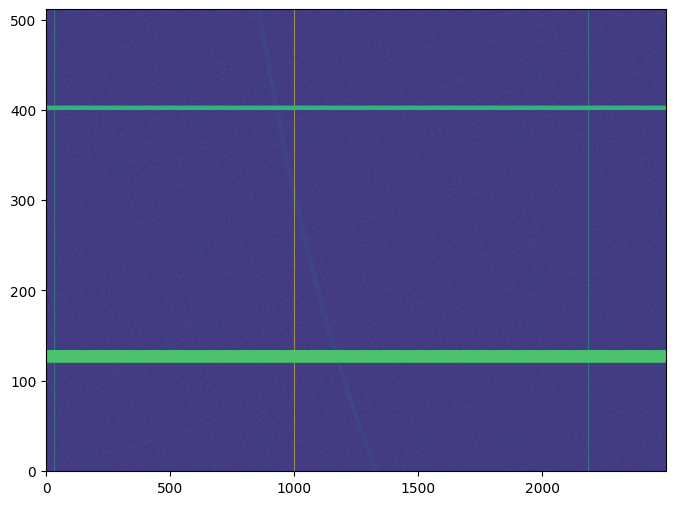

In [6]:
#initialise the plot
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)

#plot the dynamic spectrum
ax.imshow(data.T,aspect='auto',origin='lower')

plt.show()

### **Section 2: Radio Frequency Interference (RFI)**

#### **2A: The distribution of the data**

As discussed in Lecture 9, the ```Radiometer Equation``` assumes that the many sources in the sky contribute to a background of ```Gaussian random noise```. This implies that a histogram of the intensities in a radio observation which is free from RFI should follow a ```Gaussian distribution```.

In the cell below, flatten your dataset using ```data.flatten()```, and then plot the result using the matplotlib ```plt.hist()``` function.

**Hint:** Make sure to use enough bins for your histogram to see the shape properly.

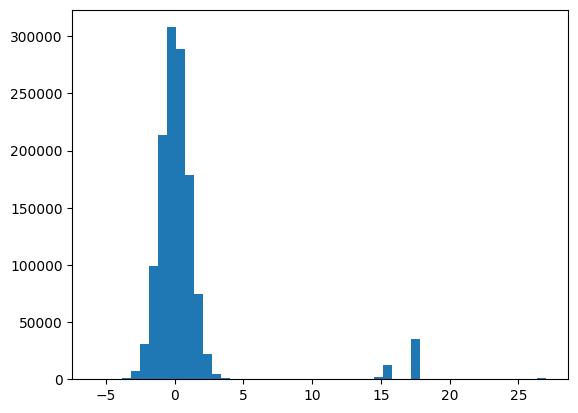

In [7]:
#Plot a histogram for your dataset in this cell


#plot the histogram
plt.hist(data.flatten(),bins=50)

plt.show()

As you should be able to see, this dataset ***does not*** have a simple Gaussian distribution. While the majority of the power is distributed in a Gaussian with a mean ~0, there is also some power visible at much higher values. This excess power is due to the RFI you saw in Section 1.

#### **2B: The Bandpass**

Now let's study the RFI more closely. From your dynamic spectrum plots in Section 1, you should have been able to see two types of RFI: ```contaminated frequency channels```, and ```oversaturated timesamples```.

The ```contaminated frequency channels``` appear as horizontal stripes of RFI. They are contained to a narrow range of observing frequencies, but they persist over the entire duration of the observation.

You can study these contaminated frequency channels more closely by looking at the ```Bandpass``` of the observation. You can create a Bandpass by averaging over the time axis of the data.

**Task:** In the cell below, plot the bandpass for this observation. To do this:

1.  Use ```data.mean()``` to average over the zeroth (time) axis of the dataset
2.  Plot the result.



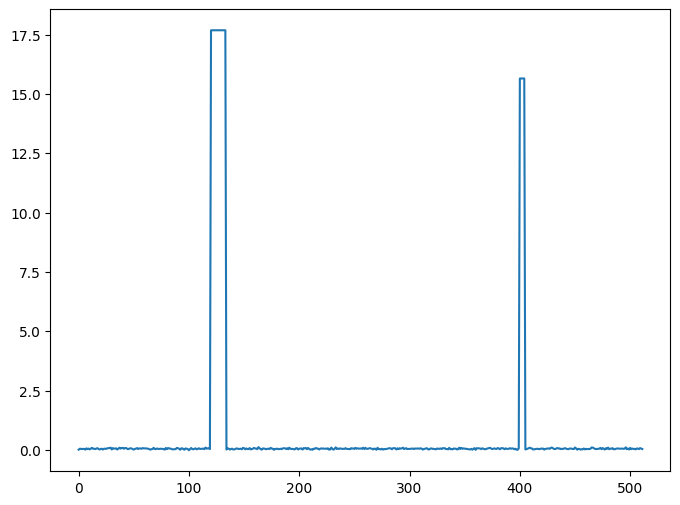

In [8]:
#Plot the bandpass for your dataset in this cell

#initialise the plot
fig = plt.figure(figsize=(8,6))
ax1 = fig.add_subplot(111)

#plot the bandpass
ax1.plot(data.mean(axis=0))

plt.show()

#### **The Timeseries**

The other type of RFI present in this dataset are the ```oversaturated timesamples```. These appear as vertical stripes of RFI -- the contamination is constrained to a short timespan, but is so strong that it affects every frequency channel observed during the affected period.

You can study these oversaturated timesamples by studying the observation's ```Timeseries```. You can create a timeseries by averaging over the frequency axis of the data.

**Task:** In the cell below, plot the timeseries for this observation. To do this:

1.  Use ```data.mean()``` to average over the first (frequency) axis of the dataset
2.  Plot the result.


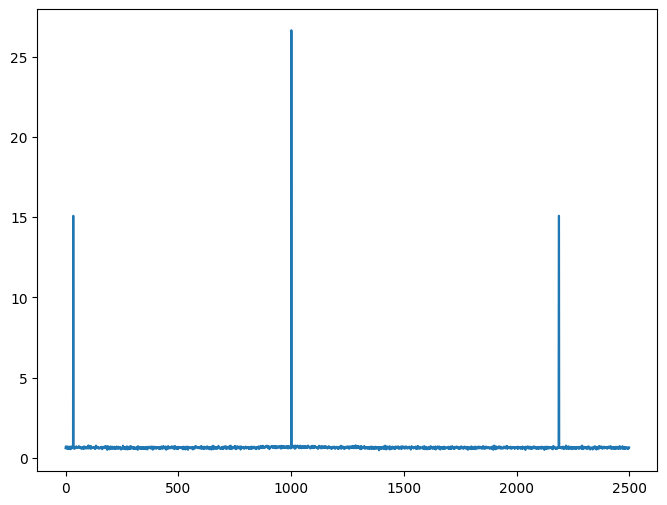

In [9]:
#Plot the timeseries for your dataset in this cell

#initialise the plot
fig = plt.figure(figsize=(8,6))
ax=fig.add_subplot(111)

#plot the timeseties
plt.plot(data.mean(axis=1))
plt.show()

### **3: RFI Mitigation**

To identify the pulsar in our observation, we will need to remove the RFI we examined in Section 2 to the best of our ability. As discussed in Lecture 9, you can mitigate RFI either by ```treating the cause``` of the RFI at an instrumental or observational level, or by ```addressing the symptoms```.

In our case, the data has already been recorded, so we have no choice but to treat the symptoms. This can be done by suppressing, discarding, or replacing the contaminated data.

We will use a combination of the masking and statistical thresholding techniques discussed in Lecture 9 to filter out our RFI.

#### **3A: Masking contaminated frequency channels**

In Section 2B we plotted the bandpass for the data, so you should have some idea already about which frequency channels are corrupted in our dataset. Now let's find the exact channels using Python.

First, take another look at the bandpass for the observation:

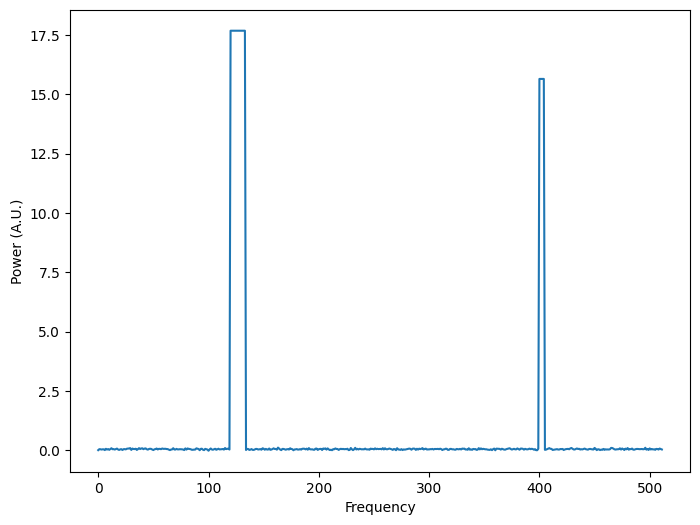

In [10]:
#initialise figure
fig = plt.figure(figsize=(8,6))
ax=fig.add_subplot(111)

#define axes
ax.set_xlabel('Frequency')
ax.set_ylabel('Power (A.U.)')

#plot the bandpass
ax.plot(data.mean(axis=0))
plt.show()

The two sets of frequency channels which are contaminated stand out clearly against the rest. The power in these channels dominates the power in other, uncontaminated channels.

One way to remove this RFI from our dataset is to mask these contaminated channels. To do this, we must identify the contaminated channels using Python.

As the statistics of the contaminated channels are so different to those of the uncontaminated channels, we can use this to our advantage.

**Task:** In the cell below, select a part of the data which is not contaminated with RFI and create the bandpass from this

In [11]:
#select a good part of the bandpass

good_channel_1 = 0 #select the first channel in the range of good channels
good_channel_2 = 100 #select the last channel in the range of good channels

good_bandpass = data[:,good_channel_1:good_channel_2].mean(axis=0) #create the bandpass for your good data

Now plot the bandpass using the uncontaminated data:

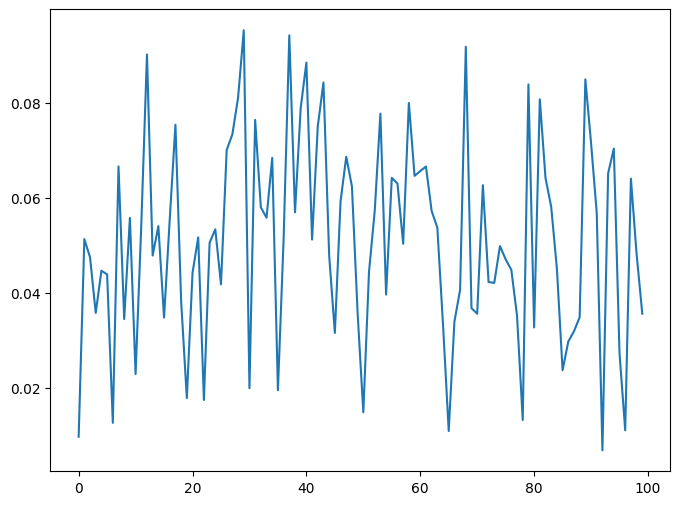

In [12]:
#Plot the good part of the bandpass in this cell

#initialise figure
fig = plt.figure(figsize=(8,6))
ax=fig.add_subplot(111)

#plot the good part of the bandpass
ax.plot(good_bandpass)
plt.show()

Now use the ```numpy.mean()``` function and the ```numpy.std()``` function to find the mean and standard deviation this part of the bandpass.

In [13]:
#find mean, standard deviation of the bandpass in this cell

mymean_f = np.mean(good_bandpass) #calculate the mean
mystdv_f = np.std(good_bandpass) #calculate the stdv

#print the mean and standard deviation of the bandpass
print('Mean: {0}, Stdv: {1}'.format(mymean_f,mystdv_f))

Mean: 0.05104038129119319, Stdv: 0.021185032842866762


Now we will use Python to identify the parts of the bandpass where the power is very large. To do this we will use the ```numpy.argwhere()``` function.

First, let's define a threshold. We will assume that if the bandpass lies above which this threshold, the corresponding frequency channel is contaminated by RFI.

Let's set this threshold to be three standard deviations away from the mean.

In [14]:
#define our threshold (3 stdvs from the mean)
condition_f = mymean_f+(3*mystdv_f)

Now use the ```np.argwhere()``` function to find all of the channels in the bandpass which are greater than this threshold. Store this information under the name ```bad_freqs```.

In [15]:
#identify any bandpass channels which are greater than the threshold
bad_freqs = np.argwhere(data.mean(axis=0)>condition_f)

print(bad_freqs)

[[120]
 [121]
 [122]
 [123]
 [124]
 [125]
 [126]
 [127]
 [128]
 [129]
 [130]
 [131]
 [132]
 [133]
 [163]
 [400]
 [401]
 [402]
 [403]
 [404]]


Now we've identified our bad frequency channels, it is time to mask them out of our original dynamic spectrum. We will do this using ```numpy```.

So that we don't completely overwrite the original dataset, first, let's make a copy of it using the ```numpy.copy()``` function. We will use this copy of the data going forward.

In [16]:
#make a copy of the original data
data_cleanedfreqs = np.copy(data)

Using our knowledge of the bad frequency channels, we will now mask out all timesamples in our dynamic spectrum which lie in these channels.

We created the list of contaminated frequency channels earlier in this Section. Remember that the time axis of the dynamic spectrum is the zeroth axis, and the frequency axis of the dynamic spectrum is the first axis.

With this knowledge, we can overwrite the data for all timesamples for only our contaminated frequency channels. Run the cell below to use numpy array manipulation to overwrite every the intensity at every timesample for each of the bad frequency channels in our list with ```np.nan``` values.

Note: it is possible to overwrite an element in an array with anything (e.g. with 0, 1, NaN, ...). But in this case, we will use ```np.nan``` values to allow us to ignore these when calculating statistics.

In [17]:
#replace all timesamples for our bad frequency channels with np.nan
data_cleanedfreqs[:,bad_freqs]=np.nan

Now plot the dynamic spectrum for our masked data in the same way that you plotted the original data in Section 1C to make sure you've masked out the timesamples correctly.

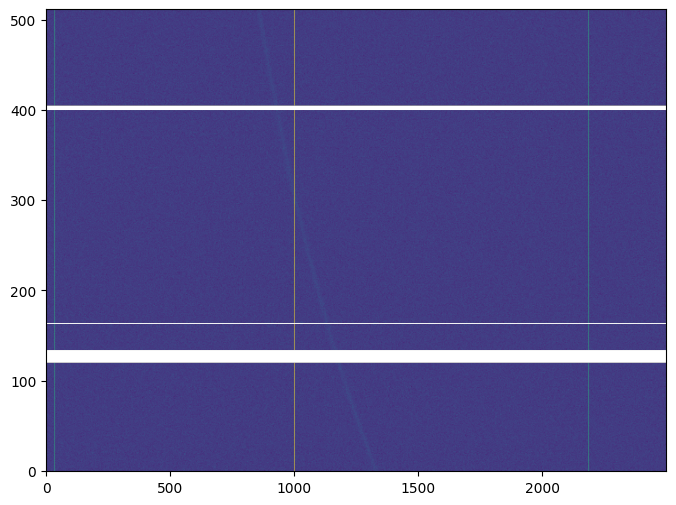

In [18]:
#plot the masked dynamic spectrum in this cell

#initialise figure
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)

#plot the frequency-masked dynamic spectrum
ax.imshow(data_cleanedfreqs.T,aspect='auto',origin='lower')

plt.show()



If you have removed the data corresponding to the contaminated frequency channels correctly, you should be able to see see gaps in the dynamic spectrum where the contaminated data used to be.

Now plot the bandpass for the masked data and inspect it.

**Note:** In previous Sections, you used ```data.mean()``` to create the bandpass from the unmasked dataset. As the masked data contains ```np.nan``` values, you should use the ```numpy.nanmean()``` function to create a bandpass from the masked dataset. For more information about this function, you can run ```np.nanmean?```.

<ipython-input-19-49e97a36112a>:10: RuntimeWarning: Mean of empty slice
  ax.plot(np.nanmean(data_cleanedfreqs,axis=0))


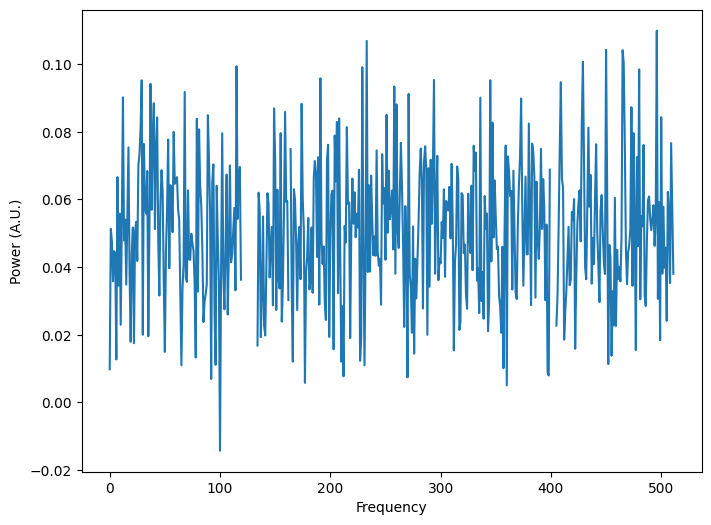

In [19]:
# plot the masked bandpass in this cell

#initialise the figure
fig = plt.figure(figsize=(8,6))
ax=fig.add_subplot(111)
ax.set_xlabel('Frequency')
ax.set_ylabel('Power (A.U.)')

#plot the masked bandpass
ax.plot(np.nanmean(data_cleanedfreqs,axis=0))
plt.show()

If you have removed the bad frequency channels correctly, the strong power in the contaminated channels will be gone, and you should be left with a bandpass that has a much smaller dynamic range.

#### **3B: Replacing bad timesamples**

As you will have seen in the previous Section, even after masking out contaminated frequency channels, there is still some RFI present. These are the times during the observation where the data was oversaturated across the entire observing bandwidth. This RFI must also be masked.

To mask the ```oversaturated timesamples```, we will follow a similar procedure to masking the bad frequency channels. First, take another look at the timeseries of the original data in the cell below:

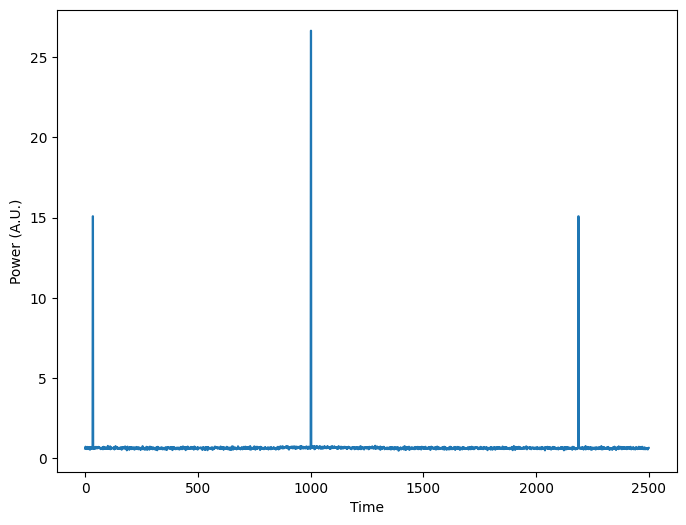

In [20]:
#initialise the plot
fig = plt.figure(figsize=(8,6))
ax=fig.add_subplot(111)
ax.set_xlabel('Time')
ax.set_ylabel('Power (A.U.)')

#plot the timeseries
ax.plot(data.mean(axis=1))

plt.show()

There are three moments where the data is oversaturated and stands out clearly against the rest of the observation.

First, let's identify these contaminated timesamples using Python. To do this, we will adapt the method we used to identify bad frequency channels in Section 3A.

First, identify a section of the timeseries which is uncontaminated and create the timeseries for only this section using ```data.mean()```

In [21]:
#select a good part of the timeseries in this cell

good_time_1 = 500 #select the first timesample in the range of good timesamples
good_time_2 = 900 #select the last timesample in the range of good timesamples

good_timeseries = data[good_time_1:good_time_2,:].mean(axis=1) #create the timeseries for your good data

Next, plot this part of the timeseries.

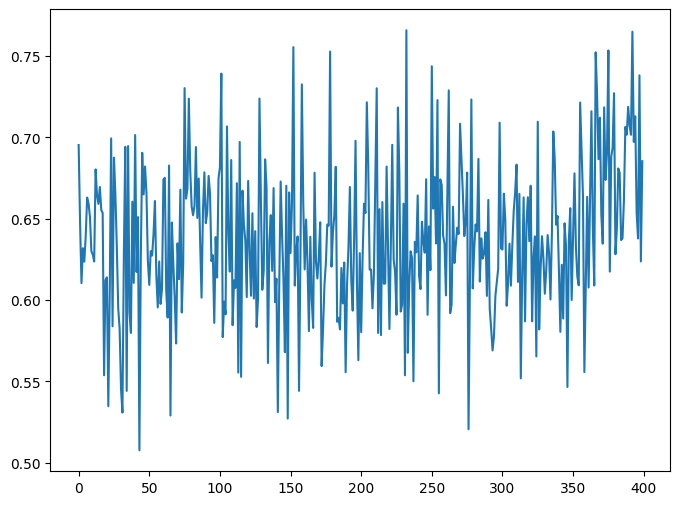

In [22]:
#plot the uncontaminated part of the timeseries in this cell

#initialise figure
fig = plt.figure(figsize=(8,6))
ax=fig.add_subplot(111)

#plot the good part of the bandpass
ax.plot(good_timeseries)
plt.show()

Now find the mean and standard deviation for this part of the timeseries using the ```numpy.mean()``` and ```numpy.std()``` functions.

In [23]:
#find mean, standard deviation of the bandpass in this cell

mymean_t = np.mean(good_timeseries) #calculate the mean
mystdv_t = np.std(good_timeseries) #calculate the stdv

print('Mean: {0}, stdv: {1}'.format(mymean_t,mystdv_t))

Mean: 0.6379819615113181, stdv: 0.045902185873813936


Now let's use Python to identify the parts of the timeseries where the power is more than three standard deviations from the mean, as we did in Section 3A for the bandpass. First, define your threshold, as you did in Section 3A:

In [24]:
#define our threshold (3 stdvs from the mean) in this cell

condition_t = mymean_t+(3*mystdv_t)

 Next, use the ```np.argwhere()``` function to identify any parts of the original timeseries which are greater than your threshold. Adapt what you learned in Section 3A to do this.

**Hint:** Make sure to average over the appropriate axis.

In [25]:
#identify any channels which meet the condition in this cell

bad_times = np.argwhere(data.mean(axis=1)>condition_t)

print(bad_times)

[[  34]
 [  35]
 [ 101]
 [1001]
 [1002]
 [1003]
 [1286]
 [2187]
 [2188]]


As we did in Section 3A, now that we've identified our bad timesamples, it's time to do some masking.

This time, we will mask the intensities corresponding to every single frequency channel for each of the times we have identified as being oversaturated.

As we did in Section 3A, so that we don't completely overwrite our partially cleaned dynamic spectrum, we will first make a copy of it using the ```numpy.copy()``` function:

In [26]:
#make a copy of the partially cleaned dataset
data_cleanedtimes = np.copy(data_cleanedfreqs)

Now adapt what you learned in Section 3A to overwrite every frequency channel in ```data_cleanedtimes``` for any oversaturated timesamples in our list with ```np.nan``` values.

**Hint:** Make sure that you are getting your axes right while overwriting the data!

In [27]:
#replace all frequency channels for our bad timesamples with np.nans in this cell

data_cleanedtimes[bad_times,:]=np.nan

When you have masked every frequency channel for our bad timesamples, plot the masked dynamic spectrum and inspect the data:

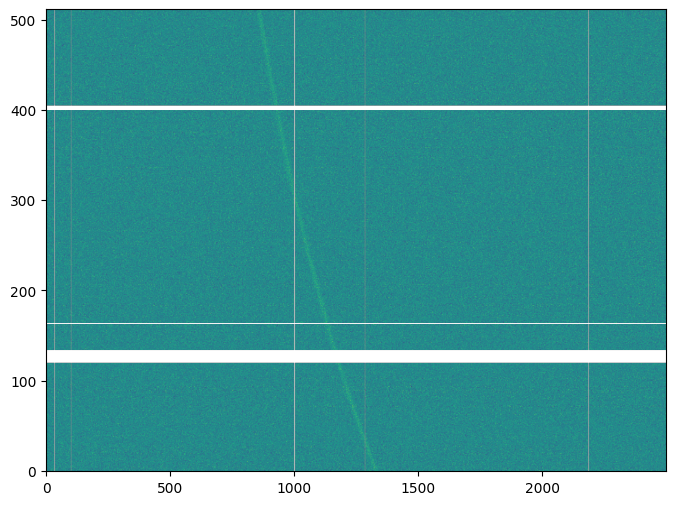

In [28]:
#plot the frequency and time-masked dynamic spectrum in this cell

#initialise the plot
fig=plt.figure(figsize=(8,6))
ax=fig.add_subplot(111)

#plot the time and freqency masked dynamic spectrum
plt.imshow(data_cleanedtimes.T,aspect='auto',origin='lower')

plt.show()

Naw that you have now removed all of the time and frequency-domain RFI, you should be able to see the dispersed pulse much more easily.

As another check, plot the timeseries for the entire masked dataset and inspect it.

Note: As in Section 3A, you will have to use the ```numpy.nanmean()``` function to create the timeseries rather than ```data_cleanedtimes.mean()``` as the dataset now contains ```np.nan``` values.

<ipython-input-29-4df214fb2ff8>:10: RuntimeWarning: Mean of empty slice
  ax.plot(np.nanmean(data_cleanedtimes,axis=1))


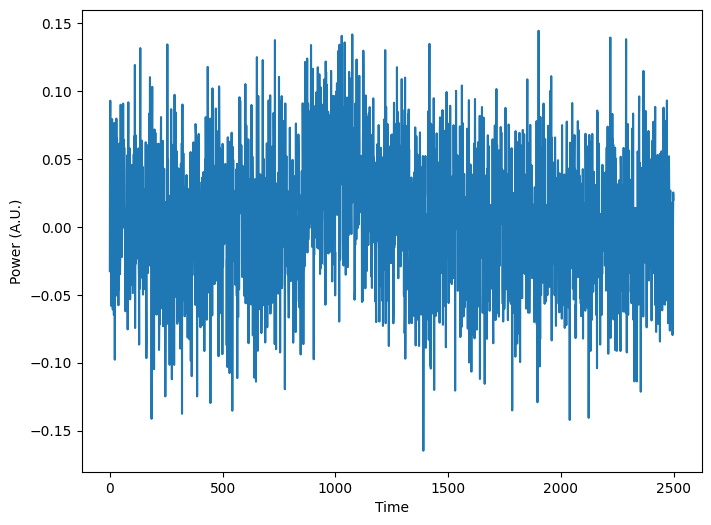

In [29]:
#plot the masked timeseries in this cell

#initialise the figure
fig = plt.figure(figsize=(8,6))
ax=fig.add_subplot(111)
ax.set_xlabel('Time')
ax.set_ylabel('Power (A.U.)')

#plot the timeseries
ax.plot(np.nanmean(data_cleanedtimes,axis=1))

plt.show()

By comparing the timeseries' of the masked and unmasked datasets, you should now be able to see that the frequency channels corresponding to oversaturated timesamples have been masked out, and the data has a much smaller dynamic range.

Also note that we cannot easily see the single pulse in the timeseries data yet. This is because the pulse has been ```dispersed``` by the ionised matter which lies between us and the source. We will undo this effect by ```dedispersing``` the data in Section 4.

To conclude this Section, finish studying the cleaned-up dataset by histogramming it using ```data_cleanedtimes.flatten()``` and the matplotlib ```plt.hist()``` function, in the same way that we histogrammed the original, contaminated dataset in Section 2A.

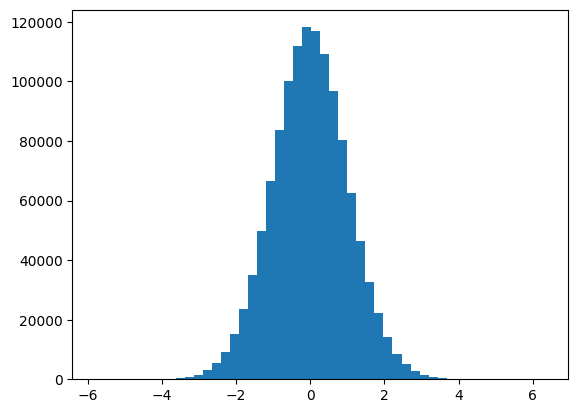

In [30]:
#plot the histogram of the masked data in this cell

plt.hist(data_cleanedtimes.flatten(),bins=50)

plt.show()

It should be immediately obvious that this masked dataset looks much more like a Gaussian distribution than the original dataset. This is because the majority of the non-Gaussian data was the RFI which has now been removed.

### **4: De-disperse the data**

#### **4A: Introduction to dedispersion**

Remember that the purpose of this Lecture is to identify which pulsar this dataset has been simulated for. To do this, we must identify the pulsar's ```Dispersion Measure (DM)```.

As discussed in Lecture 9, a radio signal which travels through an ionised medium will be ```dispersed```. We observe this dispersion as a frequency-dependent delay in the arrival time of the signal. The difference in arrival time $t$ of the parts of a signal at two frequencies $\nu_{\rm 1,obs}$ and  $\nu_{\rm 2,obs}$ is given by:

>${\Delta}t_{\rm obs}{\propto}{\rm DM_{obs}}\times\left({\nu_{\rm 1,obs}^{-2}-{\nu_{\rm 2,obs}^{-2}}}\right)$,

where the ```Dispersion Measure```, ${\rm DM_{obs}}$ is given by:

>${\rm DM_{obs}}=\int^{\rm z}_{0}\frac{\rm n_{e}}{1+{\rm z}}{\rm dl}$,

where ${\rm n_e}$ is the ```ionised electron density``` along the line of sight.

It is this dispersion which causes the characteristic sweep which you can see in our simulated dataset in Sections 1-3. For a pulsar located in our galaxy, the time delay equation can be simplified to:

>${\Delta}t_{\rm obs}\simeq4.15\times10^6\;{\rm ms}\;\times \left({\nu_{\rm 1,obs}^{-2}-{\nu_{\rm 2,obs}^{-2}}}\right)\times{\rm DM_{obs}}$.




#### **4B: An attempt at dedispersion**

In order to dedisperse our dataset, we need some more information about our simulated observation, which we didn't need before.

The information we need includes:

- The ```bandwidth``` of our observation
- The ```minimum frequency``` of our observation
- The ```sampling time``` of our observation
- The ```number of timesamples``` in our observation

This information is listed below.

In [31]:
# define observational parameters (Note: Please don't change these!)

b=400*(10**(-3))   # Frequency bandwidth of observation in GHz
mf=1200*(10**(-3)) # Minimum frequency of observation in GHz
st=5e-05 * 8          # Sampling time of observation in seconds
nt=np.size(data_cleanedtimes,0)  # Number of times sampled during observation

We can use this information to re-plot our cleaned dynamic spectrum, with axis information which will provide more physical context for the data we've been working with.

As before, we'll first make a copy of our fully masked dynamic spectrum using the ```numpy.copy()``` function in the cell below. We will be working with this copy of the data going forward.

In [32]:
#copy the fully masked dataset
obs=np.copy(data_cleanedtimes)

Now run the cell below. This will plot to plot the dynamic spectrum which you are now familiar with, including axis information:

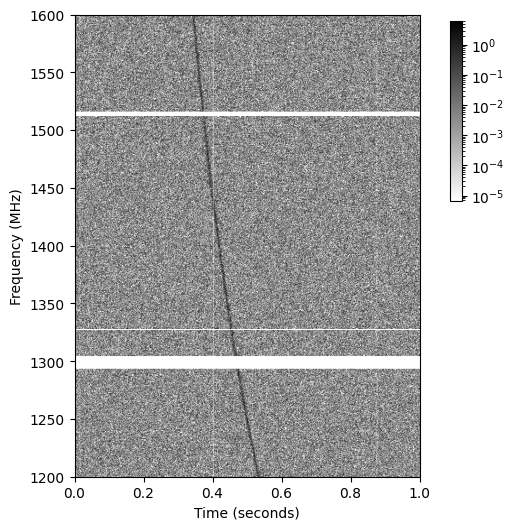

In [33]:
#initialise plot
fig=plt.figure(figsize=(6,6))
ax1 = fig.add_subplot(111)
ax1.set_xlabel('Time (seconds)')
ax1.set_ylabel('Frequency (MHz)')
extent = [0,nt*st,(mf)/(10**-3),(mf+b)/(10**-3)]

#plot the masked dynamic spectrum
im1 = ax1.imshow(obs.T,cmap='binary',aspect='auto',origin='lower',extent=extent, norm=col.LogNorm())

#create a colorbar
fig.subplots_adjust(right=0.7,wspace=0.8)
cbar_ax1 = fig.add_axes([0.75,0.57,0.02,0.3])
fig.colorbar(im1,cax=cbar_ax1)

plt.show()

To dedisperse our data, we will be using the ```dedisperse()``` function which we imported at the beginning of this lecture. To take a closer look at how this function works, run the cell below:

In [34]:
dedisperse?

We are finally ready to start dedispersing our data. In the below cell, pick a number in the range 1-250. This will serve as your first estimate for the Dispersion Measure (DM).

In [35]:
#Select a DM. Note: pick a value between 1 and 250

DM = 125

Now run the cell below. In this cell, the ```dedisperse()``` function uses information such as the observing bandwidth, minimum frequency, and sampling time to dedisperse the dynamic spectrum by a chosen DM.

This function works by rolling back the data in each frequency channel in the array by a number of timesamples calculated according to the dedispersion equations discussed in Section 4A. Therefore the ```crop()``` function should also be used to remove any unphysical parts of the dataset.

In [36]:
#dedisperse the dataset
dedispersed_obs,mroll = dedisperse(obs,DM,b,mf,st) # perform the dedispersion
dedispersed_obs = crop(dedispersed_obs,mroll)      # crop out the rollover

Now run the cell below to plot your newly dedispersed, cropped dynamic spectrum.

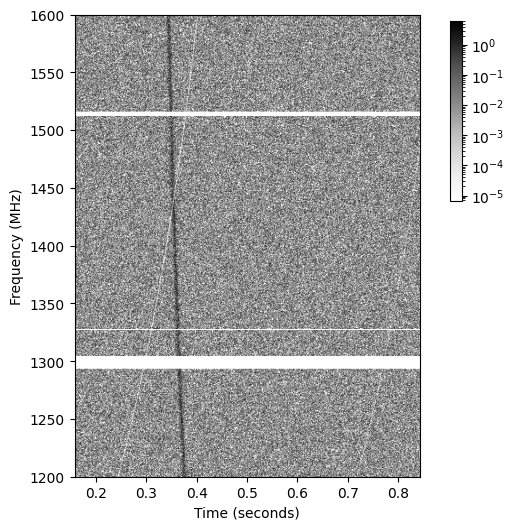

In [37]:
#initialise plot
fig=plt.figure(figsize=(6,6))
ax1 = fig.add_subplot(111)
ax1.set_xlabel('Time (seconds)')
ax1.set_ylabel('Frequency (MHz)')
extent = [(mroll*st),((nt*st)-(mroll*st)),(mf)/(10**-3),(mf+b)/(10**-3)]

#plot dedispersed pulse
im1=ax1.imshow(dedispersed_obs.T,cmap=cm.Greys,aspect='auto',origin='lower',extent=extent,norm=col.LogNorm())

#create a colorbar
fig.subplots_adjust(right=0.7,wspace=0.8)
cbar_ax1 = fig.add_axes([0.75,0.57,0.02,0.3])
fig.colorbar(im1,cax=cbar_ax1)

plt.show()

You should be able to see the effects of dedispersion in the plot above. Depending on your choice of DM, the arrival time of the pulse will have shifted as a function of frequency.

If you like, you can re-run the steps of Section 4B with a different DM to see how changing this value affects the dataset.

#### **4C: The dedispersed timeseries**
Depending on how close your chosen DM was to the true DM of the pulsar, you may now be able to see the pulse in its timeseries data. In the cell below, create a timeseries plot for your masked, dedispersed observation using the ```numpy.nanmean()``` function, just like you did for the masked data in Section 3B.

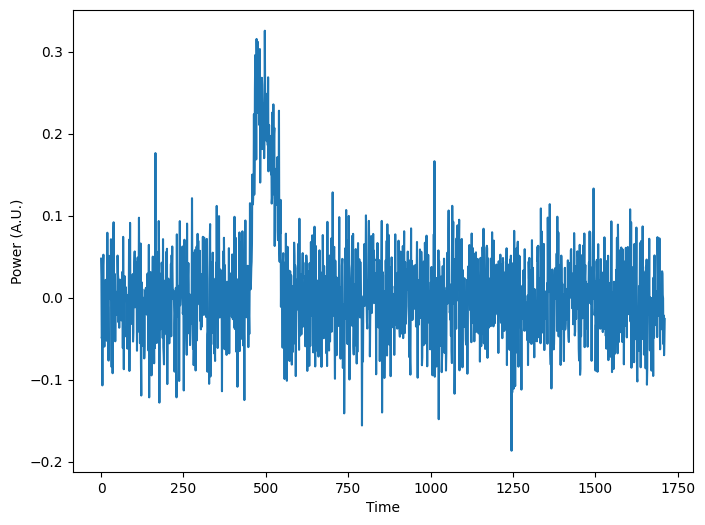

In [38]:
#plot the dedispersed timeseries in this cell

#initialise the figure
fig = plt.figure(figsize=(8,6))
ax=fig.add_subplot(111)
ax.set_xlabel('Time')
ax.set_ylabel('Power (A.U.)')

#plot the masked, dedispersed timeseries
ax.plot(np.nanmean(dedispersed_obs,axis=1))

plt.show()

Can you see the pulse with the DM you chose?

**Note:** We can also use the ```collapse()``` function which we imported at the beginning of this lessen on our cropped, dedispersed timeseries to create a time axis for our timeseries data. To create the timeseries and time axis, run the cell below:

In [39]:
#collapse the dedispersed pulse
dedispersed_t,dedispersed_signal=collapse(dedispersed_obs,st,mroll)

To plot the timeseries data against its time axis, run the cell below:

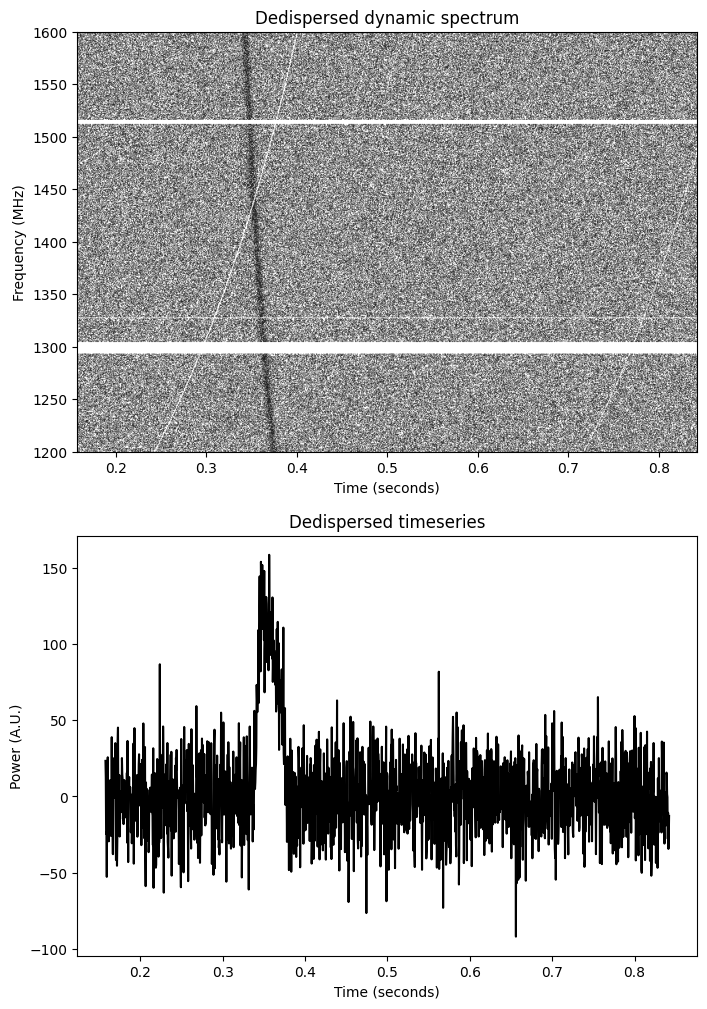

In [40]:
#initialise plot
fig = plt.figure(figsize=(8,12))
ax1 = fig.add_subplot(211) #subplot for dynamic spectrum
ax2 = fig.add_subplot(212) #subplot for timeseries

ax1.set_title('Dedispersed dynamic spectrum') #title for dynamic spectrum
ax2.set_title('Dedispersed timeseries') #title for timeseries

ax1.set_xlabel('Time (seconds)') #x-axis for dynamic spectrum
ax2.set_xlabel('Time (seconds)') #x-axis for timeseries
ax1.set_ylabel('Frequency (MHz)') #y-axis for dynamic spectrum
ax2.set_ylabel('Power (A.U.)') #y-axis for timeseries

#plot the dedispersed dynamic spectrum with its physical information
im1 = ax1.imshow(dedispersed_obs.T,cmap=cm.Greys,aspect='auto',origin='lower',extent=[(mroll*st),((nt*st)-(mroll*st)),(mf)/(10**-3),(mf+b)/(10**-3)],norm=col.LogNorm())
#plot the dedispersed timeseries with its physical information
im2 = ax2.plot(dedispersed_t,dedispersed_signal,label='signal',color='k')

plt.show()

#### **4D: Finding the true dispersion measure**

As discussed in previous Sections, the aim of this Lecture is to identify the pulsar that this data was simulated for. To do this, we must identify the true DM of the pulsar.

In Section 4A, you will have seen how the visibility of the pulse in the timeseries depends on accurately dedispersing observational data and removing the dispersive effect of any ionised material which the pulse has travelled through on its way to the observer. We are going to exploit this to identify a more accurate DM for our pulsar.

First, we need to choose a metric which we can use to gauge how accurately we have dedispersed our dataset. Herem we will use the ```signal-to-noise ratio (S/N)``` of the dedispersed pulse.

Run the cell below, to use the ```Sig_To_Noise()``` function and the ```findpeakinfo()``` function to identify the peak of the pulse in our dedispersed timeseries, and calculate the signal's S/N.

In [41]:
#calculate S/N and noise
dedispersed_SN,dedispersed_avnoise=Sig_To_Noise(dedispersed_t,dedispersed_signal,100)

#find peak
dedispersed_peaktime,dedispersed_peak = findpeakinfo(dedispersed_t,dedispersed_signal)

Now run the cell below to plot the dedispersed timeseries, and overlay its S/N information:

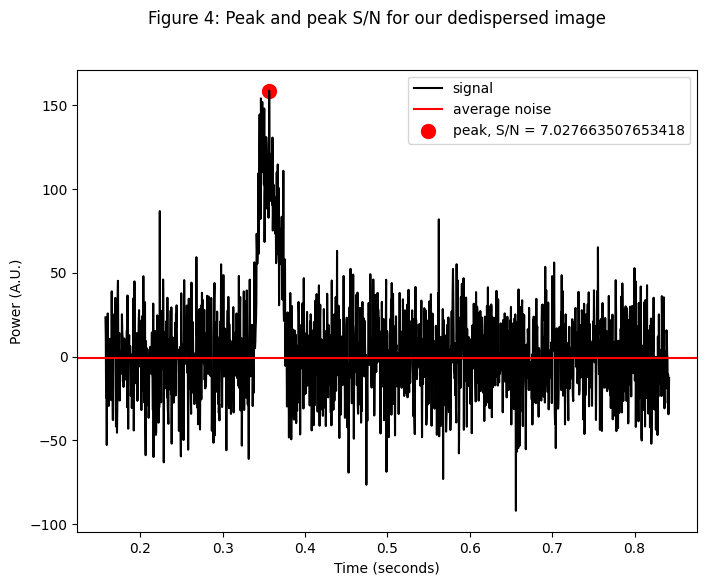

In [42]:
#initialise plot
fig=plt.figure(figsize=(8,6))
fig.suptitle('Figure 4: Peak and peak S/N for our dedispersed image',fontsize=12)
ax1 = fig.add_subplot(111)
ax1.set_xlabel('Time (seconds)')
ax1.set_ylabel('Power (A.U.)')

#plot signal
im1 = ax1.plot(dedispersed_t,dedispersed_signal,label='signal',color='k')
#plot average noise
im1 = ax1.axhline(dedispersed_avnoise,color='r',label='average noise')
#plot peak
im1 = ax1.scatter(dedispersed_peaktime,dedispersed_peak,color='r',s=100,label='peak, S/N = {}'.format(dedispersed_SN))

plt.legend()
plt.show()

Your challenge is now to put everything you've learned together. In the cell below, try to write some code to find the DM which maximises the S/N of our pulse.

**Hint:** To do this you should:


*   Use a ```for loop``` to loop over a set of dispersion measures
*   For each DM:
 *  Use the ```dedisperse()``` and ```crop()``` functions to dedisperse your cleaned observation
 * Use the ```collapse()``` function to create a timeseries from your dedispersed data
 * Use the ```Sig_To_Noise()``` function to calculate the pulse's S/N from your dedispersed timeseries
 * Store the calculated S/N.
*  Once you have looped over every DM and calculated a S/N for each, plot these against each other.

In [43]:
#Caclculate your S/N values in this cell.

#initialise empty lists to hold our values
DM_list = []
SN_list = []

#loop over a range of DMs...
for i in np.linspace(120,180,1000):

  #store the DM
  DM = i
  DM_list.append(i)

  #dedisperse the data to your desired DM
  dedispersed_obs,mroll = dedisperse(obs,DM,b,mf,st)
  dedispersed_obs = crop(dedispersed_obs,mroll)

  #collapse the dedispersed data
  dedispersed_t,dedispersed_signal = collapse(dedispersed_obs,st,mroll)

  #calculate the S/N
  dedispersed_SN,dedispersed_avnoise = Sig_To_Noise(dedispersed_t,dedispersed_signal,100)

  #store the S/N
  SN_list.append(dedispersed_SN)

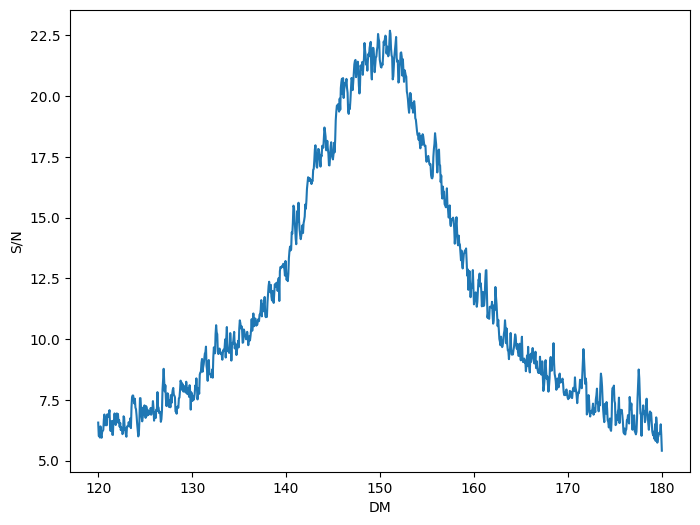

In [44]:
#Plot DM vs S/N in this cell.

#initialise figure
fig = plt.figure(figsize=(8,6))
ax=fig.add_subplot(111)
ax.set_xlabel('DM')
ax.set_ylabel('S/N')

#plot DM vs S/N
ax.plot(DM_list,SN_list)

plt.show()

Study the resulting plot of DM vs S/N. You should see that the S/N you calculate approaches its maximum as your estimated DM approaches the true DM for the pulsar. When your DM value is less than the true pulsar DM, the S/N will be reduced, as some of the pulsar's signal is being mixed into the noise. The same is true if you choos a too large DM value. This over-dedisperses the pulse, mixing some of its power into noise, and decreasing S/N.

Now we need to calculate the true DM value for this data. To do this:

1.   Find the index corresponding to the largest S/N value in your list using the ```np.argmax()``` function
2.  Return the value in your list of DMs corresponding to this index.



In [45]:
#Calculate the best DM for your observation in this cell.

#get index of best S/N
index = np.argmax(SN_list)

#get the corresponding DM which has this S/N
TrueDM = DM_list[index]

print('Index: {0}, DM: {1}'.format(index,TrueDM))

Index: 517, DM: 151.05105105105105


Congratulations! If you have done everything correctly, you should have found a best DM of ~151 pc/cc.

### **5: Identify the pulsar**

Equipped with our DM, we are finally ready to identify the pulsar that this observation was simulated for.

In the cell below is a list of four potential candidate pulsars for our dataset. The list includes the names of the pulsars, their locations on the sky in co-ordinates of ```Right Ascention (RA)``` and ```Declination (DEC)```, and a rough estimate of their distances from Earth according to a commonly used distance model known as the ```NE2001 model```.

```
|Name         |Right ascention|Declination   | d (pc) |
|-------------|---------------|--------------|--------|
|PSR B0531+21 |05h 34m 31.93s |+22° 00' 52.2 |2000    |
|PSR B0833-45 |08h 35m 20.61s |−45° 10' 34.9 |280     |
|PSR B2255+58 |22h 57m 57.74s |+59° 09' 14.8 |3000    |
|PSR B0823+26 |08h 26m 51.51s |+26° 37' 21.3 |500     |
```

It is now your job to identify which of these pulsars our data was simulated for. To do this you will use information from the ```ATNF Pulsar Catalogue```, which contains information about the many radio pulsars which have been detected by radio observatories worldwide.

To do this:

1.   Go to the ATNF pulsar catalog: https://www.atnf.csiro.au/research/pulsar/psrcat/

2.   Scroll down until you find the option to ```search by pulsar name```, and type in our pulsars.

3.   Search for 'Get Ephemeris', specifying that you want a long ephemeris. This will return a ```pulsar ephemeris``` containing a lot of information for each pulsar.

4.   For each of the four pulsars, look for the ```PSRB NAME``` and ```DM```.

5.   One of these pulsars will have a DM close to the value we have calculated. Find it, and you will have found our pulsar.




### **6: Thoughts on data intensive science**

Congratulations! You should have now correctly identified our pulsar as ```PSR B2255+58```, which has a DM of ```~151 pc/cc``` and lies at a distance of approximately 3kpc from Earth.

Now consider the data we have been working with today. You were given:

*  An idealised, simulated pulse,
*  created for a known object,
*  at a known location in the sky,
*  with a known DM,
*  and the dataset which included relatively easy-to-remove RFI.

Think about how long it took us to RFI-mitigate this dataset, dedisperse it by hand to the correct DM, and identify which of just four known pulsars it was simulated for.

Now consider what radio astronomers must do when searching for brand new signals during observational surveys. These surveys are carried out over hundreds of hours, and sample vast portions of the sky which may, or may not contain signals of interest. As we do not have any prior knowledge about what the DM of a signal we observe might be, astronomers must search over a large DM range. In addition, not all RFI looks the same, and so algorithms and techniques for RFI removal must be adaptable to different situations.

The parameter space searched by radio astronomers is orders of magnitude larger than the dataset which we have studied today. It therefore takes much longer to search for new, undiscovered pulsars and single pulses.

As radio observatories become more and more ambitious, high-performance computing, parallel processing, and machine learning will become ever more essential if we want to make the most of the huge amounts of data that we will collect. Data-intensive science is a vital skill to maximise the scientific return from projects like the SKA.

